In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skrub import GapEncoder

In [2]:
train = pd.read_parquet("train.parquet")
test = pd.read_parquet("test.parquet")

train.shape, test.shape

((17499636, 19), (4393179, 19))

In [3]:
train.head()

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
0,200,M,Shlok,paid,Johnson,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21
992,200,M,Shlok,paid,Johnson,1749042,1538352525000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",279,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,178.02404,Monster (Album Version),Skillet,2018-10-01 00:08:45,2018-08-08 13:22:21
1360,200,M,Shlok,paid,Johnson,1749042,1538352703000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",280,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,232.61995,Seven Nation Army,The White Stripes,2018-10-01 00:11:43,2018-08-08 13:22:21
1825,200,M,Shlok,paid,Johnson,1749042,1538352935000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",281,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,265.50812,Under The Bridge (Album Version),Red Hot Chili Peppers,2018-10-01 00:15:35,2018-08-08 13:22:21
2366,200,M,Shlok,paid,Johnson,1749042,1538353200000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",282,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,471.69261,Circlesong 6,Bobby McFerrin,2018-10-01 00:20:00,2018-08-08 13:22:21


In [4]:
train.columns

Index(['status', 'gender', 'firstName', 'level', 'lastName', 'userId', 'ts',
       'auth', 'page', 'sessionId', 'location', 'itemInSession', 'userAgent',
       'method', 'length', 'song', 'artist', 'time', 'registration'],
      dtype='object')

In [5]:
train.dtypes

status                    int64
gender                   object
firstName                object
level                    object
lastName                 object
userId                   object
ts                        int64
auth                     object
page                     object
sessionId                 int64
location                 object
itemInSession             int64
userAgent                object
method                   object
length                  float64
song                     object
artist                   object
time             datetime64[us]
registration     datetime64[us]
dtype: object

In [6]:
train['time'].min(), train['time'].max()

(Timestamp('2018-10-01 00:00:01'), Timestamp('2018-11-20 00:00:00'))

**Conceptual Outline**:

Our key columns are userId, time and page. We want features that describe how the user behaved before the prediction point, not after, to prevent leakage from the future. 

Thus, we define a prediction time for each user. We want to predict churn in the next 10 days, thus we need a moment in time $T_\text{pred}$ at which we pretend to make the prediction. 

Then, there are two options. 1) The user churns (has a "cancellation confirmation" event), then we set $T_\text{pred}$ 10 days before $T_\text{churn}$. 2) The user does not churn in the training set, then we set the prediction time 10 days before the last observed event. $T_\text{pred} = T_\text{pred} - 10 \text{days}$.

Everythin we compute as features must only ever use events with time before $T_\text{pred}$, otherwise we have data leakage.

**Feature 1**:

I propose "recency of activity" , i.e. days since last event, as a feature predicting churn. Users who have not done anything for a long time are more likely to churn. For each user, we look at all events with timestamp before $T_\text{pred}$ and find the last event before $T_\text{pred}$.

A possible interpretation would be: Small value: The user was active right before the prediction point and has lower churn risk. Large value: The user was inactive for many days, higher churn risk.

**Feature 2:**

I propose short-term activity level as a predictor of churn. 

We define a seven day lookback window $[T_\text{pred} - 7 \text{days}, T_\text{pred}]$. Then, we count all events in this window and construct the feature "events_last_7d". 

Rationale: Many events in the last seven days before $T_\text{pred}$ indicates that the user likes the service, uses it regularly and thus is unlikely to churn. If the user barely uses the servide, he is more likely to cancel the subscription.

**Feature 2.1:**

A very similar feature with a seven days lookback window can be included with the sole difference that we only consider songs played as events in the window. In the end, users use the service to listen to songs and thus the number of songs played in the last seven days before prediction_ts might be a better indicator of churn inclination than the total amount of events. 

In [7]:
df = train.copy()

In [8]:
# global timestamps
min_ts = df['time'].min()
max_ts = df['time'].max()
# define time deltas 
delta_7d = pd.Timedelta(days=7)
delta_10d = pd.Timedelta(days=10)

# first estimation window: observe 7 days after min_ts, predict churn in next 10 days
observation_start = min_ts
observation_end = observation_start + delta_7d
prediction_end = observation_end + delta_10d

# create mask for observation and prediction windows
obs_mask = (df['time'] >= observation_start) & (df['time'] < observation_end)
pred_mask = (df['time'] >= observation_end) & (df['time'] < prediction_end)

# check whether churn occurred in prediction window
churn_in_pred_window = df[pred_mask & (df['page'] == 'Cancellation Confirmation')]

# create subset of users present in observation window
users_in_obs_window = df[obs_mask]['userId'].unique()
df = df[df['userId'].isin(users_in_obs_window)]

# df contains users active in observation window
# restrict dataset to prediction window
df_pred_window = df[pred_mask]

# add churn flag per user
churned_users = churn_in_pred_window['userId'].unique()

# user level table: userId and binary churn flag
user_data = pd.DataFrame({'userId': users_in_obs_window})
user_data['churned'] = np.where(
    user_data['userId'].isin(churned_users), 1, 0
)

/var/folders/ch/v853cmgj3bv0njvrdjd2kdcc0000gn/T/ipykernel_50083/3662243075.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pred_window = df[pred_mask]


In [9]:
user_data['churned'].value_counts()

churned
0    12654
1      854
Name: count, dtype: int64

In [10]:
user_data

,userId,churned
0,1749042,0
1,1563081,0
2,1697168,0
3,1222580,0
4,1714398,0
...,...,...
13503,1740270,0
13504,1486999,0
13505,1216336,0
13506,1775697,0


In [ ]:
def create_features(df, observation_start, observation_end):

    # filter observation window
    obs_mask = (df['time'] >= observation_start) & (df['time'] < observation_end)
    df_obs = df[obs_mask]
    
    user_ids = df_obs['userId'].unique()
    features = pd.DataFrame({'userId': user_ids})
    
    # --- total_events: total number of events per user ---
    total_events = (
        df_obs.groupby('userId')
        .size()
        .reset_index(name='total_events')
    )
    features = features.merge(total_events, on='userId', how='left')
    
    # --- page-based features: page visit counts ---
    page_features = {
        'songs_played': 'NextSong',
        'roll_advert': 'Roll Advert',
        'settings': 'Settings',
        'add_playlist': 'Add to Playlist',
        'thumbs_up': 'Thumbs Up',
        'home': 'Home',
        'help': 'Help',
        'logout': 'Logout',
        'about': 'About',
        'upgrade': 'Upgrade',
        'submit_upgrade': 'Submit Upgrade',
        'thumbs_down': 'Thumbs Down',
        'downgrade': 'Downgrade',
        'add_friend': 'Add Friend',
        'error': 'Error',
        'save_settings': 'Save Settings',
        'submit_downgrade': 'Submit Downgrade',
        'login': 'Login',
        'register': 'Register',
        'submit_registration': 'Submit Registration',
    }
    
    for col_name, page_name in page_features.items():
        page_counts = (
            df_obs[df_obs['page'] == page_name]
            .groupby('userId')
            .size()
            .reset_index(name=col_name)
        )
        features = features.merge(page_counts, on='userId', how='left')
    
    # ------------------------------------------------------------------
    # NEW FEATURE SECTION (sessions, ratios, tenure and etc.)
    # ------------------------------------------------------------------

    # (A) Count events per session
    session_events = (
        df_obs.groupby(['userId', 'sessionId'])
        .size()
        .reset_index(name='events_in_session')
    )
    
    num_sessions = (
        session_events.groupby('userId')['sessionId']
        .nunique()
        .reset_index(name='num_sessions')
    )
    features = features.merge(num_sessions, on='userId', how='left')
    
    events_per_session = (
        session_events.groupby('userId')['events_in_session']
        .mean()
        .reset_index(name='events_per_session')
    )
    features = features.merge(events_per_session, on='userId', how='left')
    
    # (B) songs per session + song stats
    nextsong_obs = df_obs[df_obs['page'] == 'NextSong']
    
    if not nextsong_obs.empty:
        session_songs = (
            nextsong_obs.groupby(['userId', 'sessionId'])
            .size()
            .reset_index(name='songs_in_session')
        )
        
        songs_per_session = (
            session_songs.groupby('userId')['songs_in_session']
            .mean()
            .reset_index(name='songs_per_session')
        )
        features = features.merge(songs_per_session, on='userId', how='left')
        
        song_stats = (
            nextsong_obs.groupby('userId')
            .agg(
                total_song_length=('length', 'sum'),
                avg_song_length=('length', 'mean'),
                median_song_length=('length', 'median'),
            )
            .reset_index()
        )
        features = features.merge(song_stats, on='userId', how='left')
        
    # (C) Ratios
    features['song_share'] = (
        features['songs_played'] / features['total_events'].replace(0, np.nan)
    )
    features['ad_per_song'] = (
        features['roll_advert'] / features['songs_played'].replace(0, np.nan)
    )
    features['thumbs_up_rate'] = (
        features['thumbs_up'] / features['songs_played'].replace(0, np.nan)
    )
    features['thumbs_down_rate'] = (
        features['thumbs_down'] / features['songs_played'].replace(0, np.nan)
    )
    
    # (D) Page diversity + active days
    unique_pages = (
        df_obs.groupby('userId')['page']
        .nunique()
        .reset_index(name='unique_pages')
    )
    features = features.merge(unique_pages, on='userId', how='left')
    
    active_days = (
        df_obs.assign(date=df_obs['time'].dt.date)
        .groupby('userId')['date']
        .nunique()
        .reset_index(name='active_days')
    )
    features = features.merge(active_days, on='userId', how='left')
    
    # (E) tenure_days
    if 'registration' in df.columns:
        reg = df[['userId', 'registration']].drop_duplicates('userId').copy()
        
        if not np.issubdtype(reg['registration'].dtype, np.datetime64):
            reg['registration_dt'] = pd.to_datetime(reg['registration'], unit='ms')
        else:
            reg['registration_dt'] = reg['registration']
        
        reg['tenure_days'] = (observation_end - reg['registration_dt']).dt.days
        reg = reg[['userId', 'tenure_days']]
        features = features.merge(reg, on='userId', how='left')
    
    # ------------------------------------------------------------------
    # (F) userAgent cleaning and mode extraction
    # ------------------------------------------------------------------
    if 'userAgent' in df.columns:
        ua_df = df_obs[['userId', 'userAgent']].copy()
        ua_df['userAgent'] = ua_df['userAgent'].fillna("Unknown")
        ua_df['ua_clean'] = (
            ua_df['userAgent']
            .str.lower()
            .str.replace('[^a-z0-9 ]', ' ', regex=True)
            .str.replace('\s+', ' ', regex=True)
            .str.strip()
        )
        
        ua_counts = (
            ua_df.groupby(['userId', 'ua_clean'])
            .size()
            .reset_index(name='cnt')
        )
        ua_mode = (
            ua_counts
            .sort_values(['userId', 'cnt'], ascending=[True, False])
            .drop_duplicates('userId')
            [['userId', 'ua_clean']]
        )
        ua_mode = ua_mode.rename(columns={'ua_clean': 'ua_clean_mode'})
        
        features = features.merge(ua_mode, on='userId', how='left')
    
    # fill missing feature values with 0
    num_cols = features.select_dtypes(include=[np.number]).columns
    features[num_cols] = features[num_cols].fillna(0)
    
    return features

In [12]:
# create features for first observation window, then merge to user_data
features_1 = create_features(df, observation_start, observation_end)
user_data = user_data.merge(features_1, on='userId', how='left')

In [13]:
# print all the feature columns
user_data.columns.tolist()

['userId',
 'churned',
 'total_events',
 'songs_played',
 'roll_advert',
 'settings',
 'add_playlist',
 'thumbs_up',
 'home',
 'help',
 'logout',
 'about',
 'upgrade',
 'submit_upgrade',
 'thumbs_down',
 'downgrade',
 'add_friend',
 'error',
 'save_settings',
 'submit_downgrade',
 'login',
 'register',
 'submit_registration',
 'num_sessions',
 'events_per_session',
 'songs_per_session',
 'total_song_length',
 'avg_song_length',
 'median_song_length',
 'song_share',
 'ad_per_song',
 'thumbs_up_rate',
 'thumbs_down_rate',
 'unique_pages',
 'active_days',
 'tenure_days',
 'ua_clean_mode']

In [14]:
def feature_engineering(df):
    # global timestamps
    min_ts = df['time'].min()
    max_ts = df['time'].max()
    
    # define time deltas
    delta_7d = pd.Timedelta(days=7)
    delta_10d = pd.Timedelta(days=10)
    delta_14d = pd.Timedelta(days=14)

    # prediction setup: observe 14 days after min_ts, predict churn in next 10 days
    observation_start = min_ts
    observation_end = observation_start + delta_14d
    prediction_end = observation_end + delta_10d

    # --------------------------------------------------------------
    # ORIGINAL IDEA: define observation / prediction windows & label
    # --------------------------------------------------------------
    # masks on the full df
    obs_mask_all = (df['time'] >= observation_start) & (df['time'] < observation_end)
    pred_mask_all = (df['time'] >= observation_end) & (df['time'] < prediction_end)

    # users that appear in the observation window
    users_in_obs_window = df.loc[obs_mask_all, 'userId'].unique()

    # keep only those users in df (for safety / consistency)
    df_obs_users = df[df['userId'].isin(users_in_obs_window)]

    # churn events inside the prediction window for those users
    pred_mask_users = (
        (df_obs_users['time'] >= observation_end)
        & (df_obs_users['time'] < prediction_end)
    )
    churn_in_pred_window = df_obs_users[
        pred_mask_users & (df_obs_users['page'] == 'Cancellation Confirmation')
    ]

    # user-level label
    churned_users = churn_in_pred_window['userId'].unique()
    user_data = pd.DataFrame({'userId': users_in_obs_window})
    user_data['churned'] = np.where(user_data['userId'].isin(churned_users), 1, 0)

    # --------------------------------------------------------------
    # FEATURES: 14-day window (using your create_features)
    # --------------------------------------------------------------
    # this uses the full 14-day observation window: [observation_start, observation_end)
    features_14 = create_features(df_obs_users, observation_start, observation_end)
    # columns here: userId, total_events, songs_played, total_song_length, ..., ua_clean_mode
    user_data = user_data.merge(features_14, on='userId', how='left')

    # --------------------------------------------------------------
    # NEW: 7-day sub-window features inside the same 14-day window
    # --------------------------------------------------------------
    # NEW: we look at the last 7 days of the 14-day observation window:
    #      [observation_end - 7d, observation_end)
    last_7_start = observation_end - delta_7d  # NEW: start of the last 7 days
    features_7 = create_features(df_obs_users, last_7_start, observation_end)  # NEW

    # NEW: merge 7-day features; overlapping columns get suffix "_7d"
    user_data = user_data.merge(
        features_7,
        on='userId',
        how='left',
        suffixes=('', '_7d')  # NEW: base = 14d, "_7d" = last 7 days
    )

    # --------------------------------------------------------------
    # NEW: 14d vs 7d ratio features (captures recent change)
    # --------------------------------------------------------------
    # NEW: we define a small list of (14d_col, 7d_col, new_ratio_col)
    ratio_specs = [
        ('total_events',        'total_events_7d',        'event_ratio_14d_7d'),
        ('songs_played',        'songs_played_7d',        'song_ratio_14d_7d'),
        ('total_song_length',   'total_song_length_7d',   'song_length_ratio_14d_7d'),
    ]

    for col_14, col_7, col_ratio in ratio_specs:
        # only create ratio if both source columns exist
        if col_14 in user_data.columns and col_7 in user_data.columns:
            user_data[col_ratio] = user_data[col_14] / (user_data[col_7] + 1)

    # NOTE:
    # - create_features() already fills numeric NaNs with 0.
    # - Merging 7d features can introduce new NaNs if a user had no activity in last 7d.
    #   If you want, you can fill them here, but we keep the behavior minimal:
    num_cols = user_data.select_dtypes(include=[np.number]).columns
    user_data[num_cols] = user_data[num_cols].fillna(0)

    return user_data


In [ ]:
user_data_train = feature_engineering(train)

# === !!!! NEW !!! UA GapEncoder: train fit + transform ===
ua_train = (
    user_data_train['ua_clean_mode']
    .fillna("unknown")
    .astype(str)
)

ge = GapEncoder(n_components=3, random_state=42)
ua_emb_train = ge.fit_transform(ua_train)

ua_emb_train = np.asarray(ua_emb_train)

user_data_train['ua_gap_0'] = ua_emb_train[:, 0]
user_data_train['ua_gap_1'] = ua_emb_train[:, 1]
user_data_train['ua_gap_2'] = ua_emb_train[:, 2]

user_data_train.head()


In [27]:
user_data_train.columns.tolist()

['userId',
 'churned',
 'total_events',
 'songs_played',
 'roll_advert',
 'settings',
 'add_playlist',
 'thumbs_up',
 'home',
 'help',
 'logout',
 'about',
 'upgrade',
 'submit_upgrade',
 'thumbs_down',
 'downgrade',
 'add_friend',
 'error',
 'save_settings',
 'submit_downgrade',
 'login',
 'register',
 'submit_registration',
 'num_sessions',
 'events_per_session',
 'songs_per_session',
 'total_song_length',
 'avg_song_length',
 'median_song_length',
 'song_share',
 'ad_per_song',
 'thumbs_up_rate',
 'thumbs_down_rate',
 'unique_pages',
 'active_days',
 'tenure_days',
 'ua_clean_mode',
 'total_events_7d',
 'songs_played_7d',
 'roll_advert_7d',
 'settings_7d',
 'add_playlist_7d',
 'thumbs_up_7d',
 'home_7d',
 'help_7d',
 'logout_7d',
 'about_7d',
 'upgrade_7d',
 'submit_upgrade_7d',
 'thumbs_down_7d',
 'downgrade_7d',
 'add_friend_7d',
 'error_7d',
 'save_settings_7d',
 'submit_downgrade_7d',
 'login_7d',
 'register_7d',
 'submit_registration_7d',
 'num_sessions_7d',
 'events_per_sessio

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
# AutoML style implementation
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# select features and target variable
features = [
    # 14d original features
    'total_events',
    'songs_played',
    'roll_advert',
    'settings',
    'add_playlist',
    'thumbs_up',
    'home',
    'help',
    'logout',
    'about',
    'upgrade',
    'submit_upgrade',
    'thumbs_down',
    'downgrade',
    'add_friend',
    'error',
    'save_settings',
    'submit_downgrade',
    'login',
    'register',
    'submit_registration',
    'num_sessions',
    'events_per_session',
    'songs_per_session',
    'total_song_length',
    'avg_song_length',
    'median_song_length',
    'song_share',
    'ad_per_song',
    'thumbs_up_rate',
    'thumbs_down_rate',
    'unique_pages',
    'active_days',
    'tenure_days',

    # 7d new features
    'total_events_7d',
    'songs_played_7d',
    'roll_advert_7d',
    'settings_7d',
    'add_playlist_7d',
    'thumbs_up_7d',
    'home_7d',
    'help_7d',
    'logout_7d',
    'about_7d',
    'upgrade_7d',
    'submit_upgrade_7d',
    'thumbs_down_7d',
    'downgrade_7d',
    'add_friend_7d',
    'error_7d',
    'save_settings_7d',
    'submit_downgrade_7d',
    'login_7d',
    'register_7d',
    'submit_registration_7d',
    'num_sessions_7d',
    'events_per_session_7d',
    'songs_per_session_7d',
    'total_song_length_7d',
    'avg_song_length_7d',
    'median_song_length_7d',
    'song_share_7d',
    'ad_per_song_7d',
    'thumbs_up_rate_7d',
    'thumbs_down_rate_7d',
    'unique_pages_7d',
    'active_days_7d',
    'tenure_days_7d',

    # NEW ratio features
    'event_ratio_14d_7d',
    'song_ratio_14d_7d',
    'song_length_ratio_14d_7d',

    # UA-GAP embeddings (existing)
    'ua_gap_0',
    'ua_gap_1',
    'ua_gap_2'
]

target = 'churned'

X = user_data_train[features]
y = user_data_train[target]

# train validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, 
    stratify=y,  # keeps churn proportion in both sets
    random_state=42
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")

# use data and train-validation split from above
# define a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),  # we'll allow passthrough
    ('clf', LogisticRegression())  # will be replaced
])

param_distributions = [
    # Logistic Regression with regularization
    {
        'scaler': [StandardScaler(), 'passthrough'],
        'clf': [LogisticRegression(max_iter=1000, class_weight='balanced')],
        'clf__C': np.logspace(-2, 2, 10),
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs', 'liblinear']
    },
    # Random Forest
    {
        'scaler': ['passthrough'],  # trees do not need scaling
        'clf': [RandomForestClassifier(class_weight='balanced', random_state=42)],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 5, 10, 20],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    # Gradient Boosting
    {
        'scaler': ['passthrough'],  # trees do not need scaling
        'clf': [GradientBoostingClassifier(random_state=42)],
        'clf__n_estimators': [100, 200, 300],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__max_depth': [3, 5, 7]
    },
    # LightGBM
    {
        'scaler': ['passthrough'],  # trees do not need scaling
        'clf': [LGBMClassifier(objective='binary', boosting_type='gbdt', class_weight='balanced', random_state=42)],
        'clf__num_leaves': [15, 31, 63, 127],
        'clf__max_depth': [-1, 5, 8, 12],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__n_estimators': [100, 200, 400],
        'clf__min_child_samples': [10, 20, 50],
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.6, 0.8, 1.0]
    },
    # AdaBoost with Decision Tree base estimator
    {
        'scaler': ['passthrough'],  # trees do not need scaling
        'clf': [AdaBoostClassifier(
            estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=1),
            random_state=42
        )],
        'clf__n_estimators': [50, 100, 200, 400],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0]
    }
]

# Configure AutoML Search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=50,  # number of parameter settings sampled
    scoring='balanced_accuracy',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)
# refit=True by default, the best hyperparameters are used to refit the model on the whole training set

# run the search
search.fit(X_train, y_train)

print("Best CV balanced acuracy:", search.best_score_)
print("Best parameters:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")
best_model = search.best_estimator_

# predict the valdation set
y_pred = best_model.predict(X_val)

# performance metrics
acc = accuracy_score(y_val, y_pred)
bacc = balanced_accuracy_score(y_val, y_pred)

print("Classification report:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bacc:.4f}")

Training set size: 13016 samples
Validation set size: 3255 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 528, number of negative: 9884
[LightGBM] [Info] Number of positive: 529, number of negative: 9884
[LightGBM] [Info] Number of positive: 529, number of negative: 9884
[LightGBM] [Info] Number of positive: 529, number of negative: 9884
[LightGBM] [Info] Number of positive: 529, number of negative: 9884
[LightGBM] [Info] Number of positive: 528, number of negative: 9884
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__max_depth=5, clf__min_child_samples=10, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.6, scaler=passthrough; total time=  10.4s
[CV] END clf=GradientBoostingClassifier(random_state=42), clf__learning_rate=0.01, clf__max_depth=3, clf__n_estimators=200, scaler=passthrough; total time=  31.9s


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=-1, clf__min_child_samples=50, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8, scaler=passthrough; total time=   7.7s


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=-1, clf__min_child_samples=50, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8, scaler=passthrough; total time=   9.0s


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=-1, clf__min_child_samples=50, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8, scaler=passthrough; total time=   8.9s
[LightGBM] [Info] Number of positive: 528, number of negative: 9884
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8096
[LightGBM] [Info] Number of data points in the train set: 10412, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_dept

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=LogisticRegression(class_weight='balanced', max_iter=1000), clf__C=35.93813663804626, clf__penalty=l2, clf__solver=lbfgs, scaler=passthrough; total time=   3.8s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 528, number of negative: 9884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8096
[LightGBM] [Info] Number of data points in the train set: 10412, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_samples=10, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8, scaler=passthrough; total time=  15.3s
[LightGBM] [Info] Number of positive: 529, number of negative: 9884
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8116
[LightGBM] [Info] Number of data points in the train set: 10413, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 529, number of negative: 9884
[Li

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 528, number of negative: 9884
[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_samples=50, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8, scaler=passthrough; total time=  28.0s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8096
[LightGBM] [Info] Number of data points in the train set: 10412, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__max_de

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best CV balanced acuracy: 0.6691982176662362
Best parameters:
  scaler: passthrough
  clf__n_estimators: 400
  clf__learning_rate: 0.1
  clf: AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=1),
                   random_state=42)
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.72      0.82      3090
           1       0.10      0.59      0.17       165

    accuracy                           0.71      3255
   macro avg       0.54      0.65      0.50      3255
weighted avg       0.93      0.71      0.79      3255

Accuracy: 0.7094
Balanced Accuracy: 0.6547


In [30]:
best_model

Pipeline(steps=[('scaler', 'passthrough'),
                ('clf',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=1),
                                    learning_rate=0.1, n_estimators=400,
                                    random_state=42))])

**Test Estimation for Kaggle upload**

We run our best model on the so far unseen test data, compute the binary predictions and upload this attempt to kaggle.

In [31]:
def feature_engineering_test(df):
    # global timestamps
    min_ts = df['time'].min()
    max_ts = df['time'].max()

    delta_7d = pd.Timedelta(days=7)
    delta_14d = pd.Timedelta(days=14)

    # observation window for test: last 14 days of the dataset
    observation_start = max_ts - delta_14d
    observation_end = max_ts

    # mask for observation window
    obs_mask_all = (df['time'] >= observation_start) & (df['time'] < observation_end)

    # users that appear in the observation window
    users_in_obs_window = df.loc[obs_mask_all, 'userId'].unique()

    # restrict df to those users
    df_obs = df[df['userId'].isin(users_in_obs_window)]

    # base user table for test users
    user_data_obs = pd.DataFrame({'userId': users_in_obs_window})

    # --------------------------------------------------------------
    # 14-day features (same as train, using the same create_features)
    # --------------------------------------------------------------
    features_14 = create_features(df_obs, observation_start, observation_end)
    user_data_obs = user_data_obs.merge(features_14, on='userId', how='left')

    # --------------------------------------------------------------
    # NEW: 7-day sub-window features for test
    # --------------------------------------------------------------
    # NEW: last 7 days of the 14-day observation window:
    #      [observation_end - 7d, observation_end)
    last_7_start = observation_end - delta_7d  # NEW
    features_7 = create_features(df_obs, last_7_start, observation_end)  # NEW

    # NEW: merge 7-day features; overlapping columns get suffix "_7d"
    user_data_obs = user_data_obs.merge(
        features_7,
        on='userId',
        how='left',
        suffixes=('', '_7d')  # NEW: 7d features get "_7d" suffix
    )

    # --------------------------------------------------------------
    # NEW: same 14d vs 7d ratio features as in train
    # --------------------------------------------------------------
    ratio_specs = [
        ('total_events',        'total_events_7d',        'event_ratio_14d_7d'),
        ('songs_played',        'songs_played_7d',        'song_ratio_14d_7d'),
        ('total_song_length',   'total_song_length_7d',   'song_length_ratio_14d_7d'),
    ]

    for col_14, col_7, col_ratio in ratio_specs:
        if col_14 in user_data_obs.columns and col_7 in user_data_obs.columns:
            user_data_obs[col_ratio] = user_data_obs[col_14] / (user_data_obs[col_7] + 1)

    num_cols = user_data_obs.select_dtypes(include=[np.number]).columns
    user_data_obs[num_cols] = user_data_obs[num_cols].fillna(0)

    # --------------------------------------------------------------
    # keep all userIds from the original test, merge with obs users
    # --------------------------------------------------------------
    all_users = df['userId'].unique()
    user_base_test = pd.DataFrame({'userId': all_users})
    user_base_test = user_base_test.merge(user_data_obs, on='userId', how='left')

    return user_base_test


In [32]:
user_data_test = feature_engineering_test(test)

# === NEW !!!!! UA GapEncoder ===
ua_test = (
    user_data_test['ua_clean_mode']
    .fillna("unknown")
    .astype(str)
)

ua_emb_test = ge.transform(ua_test)
ua_emb_test = np.asarray(ua_emb_test)

user_data_test['ua_gap_0'] = ua_emb_test[:, 0]
user_data_test['ua_gap_1'] = ua_emb_test[:, 1]
user_data_test['ua_gap_2'] = ua_emb_test[:, 2]

# ====================================================================
user_data_test.fillna(0, inplace=True)
user_data_test.head()

,userId,total_events,songs_played,roll_advert,settings,add_playlist,thumbs_up,home,help,logout,...,unique_pages_7d,active_days_7d,tenure_days_7d,ua_clean_mode_7d,event_ratio_14d_7d,song_ratio_14d_7d,song_length_ratio_14d_7d,ua_gap_0,ua_gap_1,ua_gap_2
0,1465194,426.0,351.0,7.0,1.0,10.0,19.0,12.0,2.0,3.0,...,13.0,4.0,53.0,mozilla 5 0 windows nt 6 1 wow64 applewebkit 5...,1.560440,1.560000,1.561110,1.056096,0.000675,0.000891
1,1261737,166871.0,0.0,0.0,0.0,0.0,0.0,87522.0,5651.0,0.0,...,7.0,7.0,49.0,unknown,2.027841,0.000000,0.000000,0.000777,0.006895,0.000349
2,1527155,351.0,301.0,0.0,3.0,5.0,13.0,8.0,3.0,4.0,...,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,1.013652,0.000968,0.001196
3,1507202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,0.000777,0.006895,0.000349
4,1429412,2288.0,1923.0,0.0,10.0,53.0,108.0,77.0,12.0,19.0,...,11.0,7.0,76.0,mozilla 5 0 iphone cpu iphone os 7 1 2 like ma...,1.416718,1.416053,1.417149,0.001201,0.575198,0.774186


In [33]:
X = user_data_test[features]

# predict in two cases: churn (0) if no data available for user
missing_mask = X.isna().any(axis=1)

# initialize predictions array: churn prediction is zero
y_pred = np.zeros(X.shape[0], dtype=int)
# predict for users with data

# users with data
X_valid = X[~missing_mask]
y_pred_valid = best_model.predict(X_valid)

# write predictions in at correct positions
y_pred[~missing_mask] = y_pred_valid


# create dataframe with userId and predictions
predictions_df = pd.DataFrame({
    'id': user_data_test['userId'],
    'target': y_pred
})

predictions_df.head(10)

,id,target
0,1465194,1
1,1261737,1
2,1527155,0
3,1507202,0
4,1429412,1
5,1778785,1
6,1776591,1
7,1937373,1
8,1959334,0
9,1138878,0


In [34]:
X.shape, y_pred.shape

((2904, 74), (2904,))

In [35]:
# export as csv
predictions_df.to_csv("churn_predictions.csv", index=False)

In [36]:
predictions_df.shape

(2904, 2)

In [37]:
# count values of predictions_df target
predictions_df['target'].mean()

0.4015151515151515

In [ ]:
import inspect

def extract_final_estimator(model):
    if hasattr(model, "named_steps"):
        # sklearn Pipeline
        return list(model.named_steps.values())[-1]
    return model


def plot_model_importance(model, X, top_n=20):
    estimator = extract_final_estimator(model)
    feature_names = X.columns


    from sklearn.linear_model import LogisticRegression
    if isinstance(estimator, LogisticRegression):
        coefs = estimator.coef_.ravel()
        
        df_imp = pd.DataFrame({
            "feature": feature_names,
            "coef": coefs,
            "abs_coef": np.abs(coefs)
        }).sort_values("abs_coef", ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 8))
        plt.barh(df_imp["feature"][::-1], df_imp["coef"][::-1])
        plt.title(f"Top {top_n} Logistic Regression Coefficients")
        plt.xlabel("Coefficient (positive → churn ↑)")
        plt.tight_layout()
        plt.show()
        return df_imp

    if hasattr(estimator, "feature_importances_"):
        importances = estimator.feature_importances_
        
        df_imp = pd.DataFrame({
            "feature": feature_names,
            "importance": importances
        }).sort_values("importance", ascending=False).head(top_n)

        plt.figure(figsize=(10, 8))
        plt.barh(df_imp["feature"][::-1], df_imp["importance"][::-1])
        plt.title(f"Top {top_n} Tree-model Feature Importances")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()
        return df_imp

    raise ValueError(f"Model type {type(estimator)} has no recognized feature importance method.")


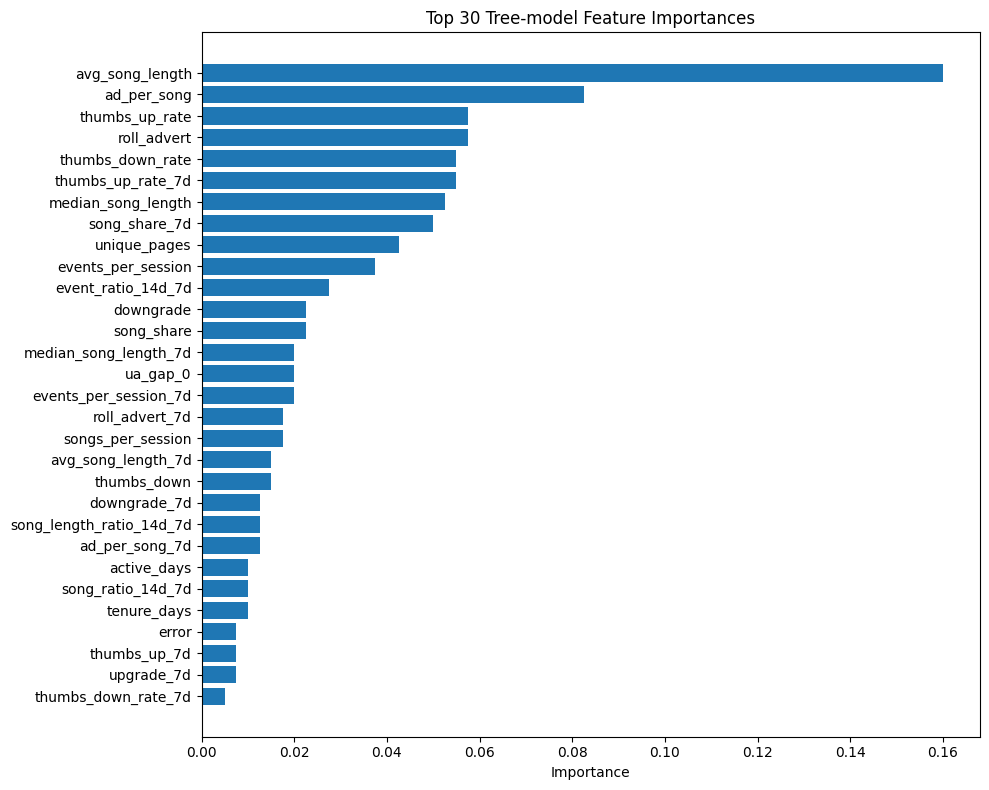

,feature,importance
25,avg_song_length,0.1600
28,ad_per_song,0.0825
29,thumbs_up_rate,0.0575
2,roll_advert,0.0575
30,thumbs_down_rate,0.0550
63,thumbs_up_rate_7d,0.0550
26,median_song_length,0.0525
61,song_share_7d,0.0500
31,unique_pages,0.0425
22,events_per_session,0.0375


In [39]:
plot_model_importance(best_model, X_train, top_n=30)
